# PyTorch ResNet-50 CIFAR-10 Benchmarks

In [1]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         39 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  16
  On-line CPU(s) list:   0-15
Vendor ID:               GenuineIntel
  Model name:            11th Gen Intel(R) Core(TM) i7-11700 @ 2.50GHz
    CPU family:          6
    Model:               167
    Thread(s) per core:  2
    Core(s) per socket:  8
    Socket(s):           1
    Stepping:            1
    CPU max MHz:         4900.0000
    CPU min MHz:         800.0000
    BogoMIPS:            4992.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf tsc_known_freq pni pclmulqd

In [2]:
!nvidia-smi

Tue Jun 27 19:39:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| 79%   53C    P8              11W / 130W |     63MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## device=cuda:0

In [3]:
import torch
import torchvision

In [4]:
LR = 0.01
DOWNLOAD = True
DATA = 'datasets/cifar10/'
device = 'cuda:0'

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=True,
        transform=transform,
        download=DOWNLOAD
)

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=64,
        
)

test_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=False,
        transform=transform,
        download=DOWNLOAD
)

test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=128,
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
model = torchvision.models.resnet50()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=0.9)

In [7]:
%%time

accuracy = 0
loss_iter_plot = []
loss_epoch_plot = []
accuracy_plot = []

model.train()

for epoch in range(300):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_iter_plot.append(loss.item())
    
    loss_epoch_plot.append(loss.item())
    
    model.eval()
    
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = (correct / total) * 100
    accuracy_plot.append(accuracy)
    print(f"epoch = {epoch}, loss = {loss.item()}, accuracy = {accuracy:.2f}")
    
    model.train()


/home/dlewis/miniconda3/envs/mlenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


epoch = 0, loss = 1.9514214992523193, accuracy = 43.71
epoch = 1, loss = 1.5855259895324707, accuracy = 60.84
epoch = 2, loss = 1.2572696208953857, accuracy = 64.44
epoch = 3, loss = 0.6162101030349731, accuracy = 71.70
epoch = 4, loss = 0.228501558303833, accuracy = 70.23
epoch = 5, loss = 0.16014787554740906, accuracy = 73.34
epoch = 6, loss = 0.6181645393371582, accuracy = 70.63
epoch = 7, loss = 0.21589496731758118, accuracy = 70.15
epoch = 8, loss = 0.11138337850570679, accuracy = 71.34
epoch = 9, loss = 0.08046340197324753, accuracy = 69.57
epoch = 10, loss = 0.024554256349802017, accuracy = 75.03
epoch = 11, loss = 0.00855736993253231, accuracy = 77.10
epoch = 12, loss = 0.0026750373654067516, accuracy = 75.21
epoch = 13, loss = 0.18017934262752533, accuracy = 76.20
epoch = 14, loss = 0.0018380656838417053, accuracy = 79.50
epoch = 15, loss = 0.01201550755649805, accuracy = 79.25
epoch = 16, loss = 0.00011307873501209542, accuracy = 79.76
epoch = 17, loss = 0.0017156492685899138

KeyboardInterrupt: 

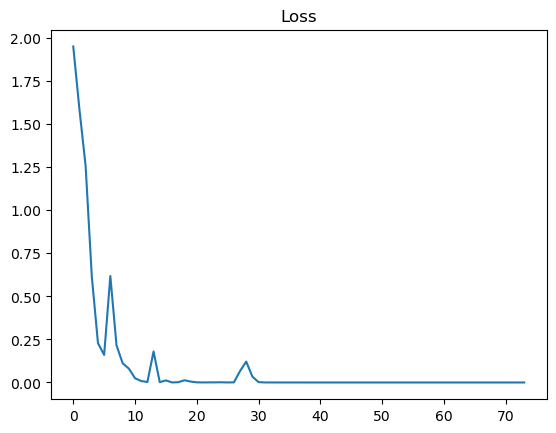

In [8]:
import matplotlib.pyplot as plt

X = range(len(loss_epoch_plot))
Y_loss = loss_epoch_plot
plt.plot(X, Y_loss)
plt.title("Loss")
plt.show()

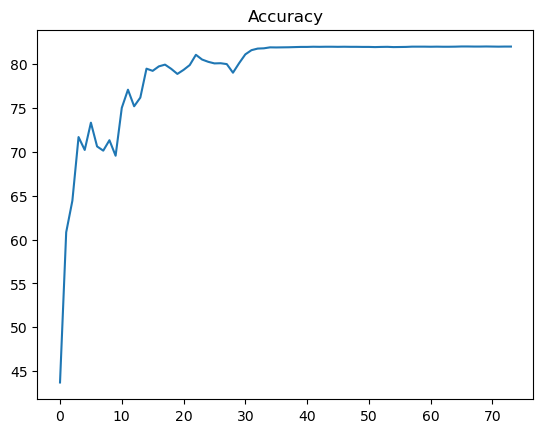

In [9]:
X_accuracy = range(len(accuracy_plot))
Y_accuracy = accuracy_plot
plt.plot(X_accuracy, Y_accuracy)
plt.title("Accuracy")
plt.show()

In [10]:
torch.save({
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     }, 'checkpoint.pth')